In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt

In [2]:
# Load the data
df = pd.read_csv('.csv/cleaned_data.csv', index_col = 0)
model_data = df.copy()
pd.set_option('display.max_column', None)

In [3]:
# Data for iterative imputing
logit_data = df.copy()

In [4]:
logit_data.replace(np.inf, np.nan, inplace=True)

In [5]:
logit_data['NewExist_Encoded'] = logit_data['NewExist'].map({1.0 : 1, 2.0: 2, np.nan: 0})
logit_data['UrbanRural_Encoded'] = logit_data['UrbanRural'].map({1.0 : 1, 2.0: 2, 0.0: 0}).fillna(0).astype('int64')
logit_data['MIS_Status_Encoded'] = logit_data['MIS_Status'].map({'CHGOFF': 0, 'PIF': 1})
logit_data['RevLineCr_Encoded'] = logit_data['RevLineCr'].map({'N': 1, 'Y': 2}).fillna(0).astype('int64')
logit_data['LowDoc_Encoded'] = logit_data['LowDoc'].map({'N': 0, 'Y': 1})
logit_data['FranchiseCode_Encoded'] = logit_data['FranchiseCode_Encoded'].map({'No': 0, 'Yes': 1}).astype('int64')
logit_data['RealEstate_Backed'] = logit_data['RealEstate_Backed'].map({'No': 0, 'Yes': 1}).astype('int64')
logit_data['CreateJob_Encoded'] = logit_data['CreateJob'].apply(lambda x: 1 if x > 0 else 0)
logit_data['RetainedJob_Encoded'] = logit_data['RetainedJob'].apply(lambda x: 1 if x > 0 else 0)

In [6]:
logit_data.loc[:, 'EmployeeLoanRatio'] = logit_data.apply(
    lambda row: round(row['GrAppv']) if pd.isna(row['EmployeeLoanRatio']) else round(row['EmployeeLoanRatio']),
    axis=1
).astype('int64')

In [7]:
logit_data.drop(labels=['LoanNr_ChkDgt', 'Name', 'City', 'Bank', 'BankState', 'TermDays', 'ApprovalDate', 'ApprovalFY', 'Zip', 'DisbursementDate', 
                      'DisbursementGross','NewExist', 'RetainedJob', 'LowDoc' ,'UrbanRural', 'RevLineCr', 'ChgOffDate',
                      'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'SBA_Appv', 'Industry', 'Recession',
                       'ApprovalDateYear', 'ChgOffDateYear', 'ApprovalDateMonth', 'DisbursementDateYear',
                       'LoanDateEnd'], axis=1, inplace=True )

#### One-Hot Encode categories

In [8]:
# One Hot-Encode the categorical variables
logit_data = pd.get_dummies(logit_data, columns=['State', 'Region', 'StateRisk']).fillna(0).astype('int64')

#### Check for Multicollinearity

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(logit_data.drop(columns=['MIS_Status_Encoded']))

# Calculate the VIF for each feature
vif = pd.DataFrame()
vif["features"] = logit_data.drop(columns=['MIS_Status_Encoded']).columns
vif["VIF Factor"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

vif['VIF Factor'] = round(vif['VIF Factor'], 2)

# Print the results
vif

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,features,VIF Factor
0,NAICS,1.31
1,Term,4.82
2,NoEmp,1.02
3,CreateJob,1.01
4,FranchiseCode,4.21
...,...,...
70,Region_Southern,inf
71,Region_Western,inf
72,StateRisk_High,inf
73,StateRisk_Low,inf


#### Validate Linearity Assumption

- Perform Box-Tidwell test to examine the relationship between continous predictor variables and their logit.

In [12]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler


# Create DataFrame
df_test = logit_data[['MIS_Status_Encoded', 'GrAppv', 'CreateJob', 'NAICS', 'Term', 'NoEmp', 'EmployeeLoanRatio']]

# Select predictor features
continuous_features = df_test[['GrAppv', 'CreateJob', 'NAICS', 'Term', 'NoEmp', 'EmployeeLoanRatio']]

# Standardize the features
scaler = StandardScaler()
continuous_features = scaler.fit_transform(continuous_features)

# Convert the features to a DataFrame (RESTORE INDEX)
continuous_features = pd.DataFrame(continuous_features, 
                                   columns=['GrAppv', 'CreateJob', 'NAICS', 'Term', 'NoEmp', 'EmployeeLoanRatio'],
                                   index=df_test.index)

# Create interaction terms
for col in continuous_features.columns:
    continuous_features[f'log_{col}'] = np.log(continuous_features[col].replace(0, 1e-9))
    continuous_features[f'interaction_{col}'] = continuous_features[col] * continuous_features[f'log_{col}']

# Handle infinities and NaNs
continuous_features.replace([np.inf, -np.inf], np.nan, inplace=True)
continuous_features.fillna(0, inplace=True)

# Target feature
y = df_test['MIS_Status_Encoded'].loc[continuous_features.index]  # Ensure alignment

# Concatenate features and target
X = continuous_features.copy()

# Reset index to avoid mismatches
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Add constant for logistic regression
X = sm.add_constant(X)

# Fit logistic regression model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# Display results
print(result.summary())

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/michaeladebayo/Documents/Simplon/brief_pr

Optimization terminated successfully.
         Current function value: 0.374416
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:     MIS_Status_Encoded   No. Observations:               897428
Model:                          Logit   Df Residuals:                   897409
Method:                           MLE   Df Model:                           18
Date:                Mon, 17 Feb 2025   Pseudo R-squ.:                  0.1949
Time:                        23:09:16   Log-Likelihood:            -3.3601e+05
converged:                       True   LL-Null:                   -4.1735e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             2.4414      0.008    319.188      0.

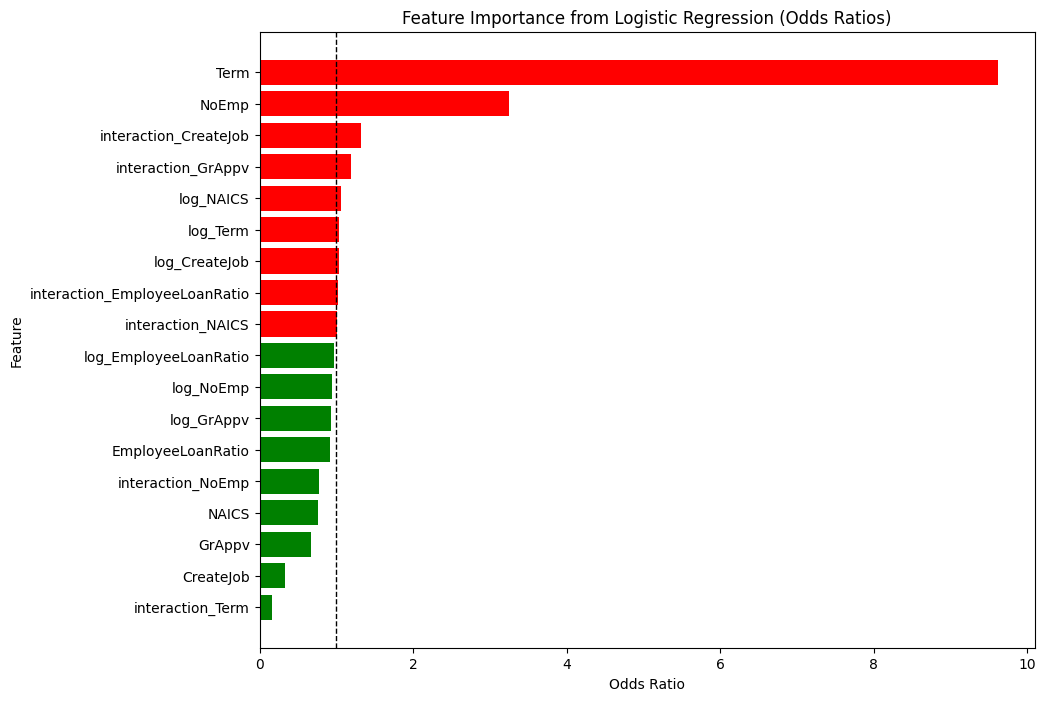

In [13]:
# Extract the coefficients from the logistic regression results
coefficients = result.params
feature_names = coefficients.index

# Calculate the odds ratios by exponentiating the coefficients
odds_ratios = np.exp(coefficients)

# Create a DataFrame with the feature names and their corresponding odds ratios
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Odds Ratio': odds_ratios,
    'Coefficient': coefficients
})

# Exclude the constant term
feature_importance = feature_importance[feature_importance['Feature'] != 'const']

# Sort the features by odds ratio
feature_importance = feature_importance.sort_values(by='Odds Ratio', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 8))
colors = ['red' if coef > 0 else 'green' for coef in feature_importance['Coefficient']]
plt.barh(feature_importance['Feature'], feature_importance['Odds Ratio'], color=colors)
plt.axvline(x=1, color='black', linestyle='--', linewidth=1)  # Reference line at OR=1
plt.xlabel('Odds Ratio')
plt.ylabel('Feature')
plt.title('Feature Importance from Logistic Regression (Odds Ratios)')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

#### Chi-Square Test (Categorial features vs Target)

- Evaluate if the relationship between categorical features and the target are significant.

In [15]:
from scipy.stats import chi2_contingency

def create_chi2(df, target, categorical_features):
    # Initialize a list to store results
    chi2_results = []

    # Perform the chi-square test for each categorical feature
    for feature in categorical_features:
        contingency_table = pd.crosstab(df[feature], df[target])  # Create contingency table
        chi2_stat, p, dof, expected = chi2_contingency(contingency_table)  # Chi-square test

        # Append results as a dictionary
        chi2_results.append({'Feature': feature, 'Chi2 Statistic': chi2_stat, 'p-value': p})

    # Convert list to DataFrame
    return pd.DataFrame(chi2_results)

# Define the categorical features
categorical_features = ['NAICS_class_code', 'FranchiseCode_Encoded', 'RealEstate_Backed', 'EmployeeLoanRatio', 'NewExist_Encoded',
                        'UrbanRural_Encoded', 'RevLineCr_Encoded',
                        'LowDoc_Encoded', 'CreateJob_Encoded', 'RetainedJob_Encoded',
                        'State_AK', 'State_AL', 'State_AR', 'State_AZ', 'State_CA', 'State_CO',
                        'State_CT', 'State_DC', 'State_DE', 'State_FL', 'State_GA', 'State_HI',
                        'State_IA', 'State_ID', 'State_IL', 'State_IN', 'State_KS', 'State_KY',
                        'State_LA', 'State_MA', 'State_MD', 'State_ME', 'State_MI', 'State_MN',
                        'State_MO', 'State_MS', 'State_MT', 'State_NC', 'State_ND', 'State_NE',
                        'State_NH', 'State_NJ', 'State_NM', 'State_NV', 'State_NY', 'State_OH',
                        'State_OK', 'State_OR', 'State_PA', 'State_RI', 'State_SC', 'State_SD',
                        'State_TN', 'State_TX', 'State_UT', 'State_VA', 'State_VT', 'State_WA',
                        'State_WI', 'State_WV', 'State_WY', 'Region_Eastern', 'Region_Northern',
                        'Region_Southern', 'Region_Western', 'StateRisk_High', 'StateRisk_Low',
                        'StateRisk_Medium']

       
# Call the function and store the results
chi2_results = create_chi2(logit_data, 'MIS_Status_Encoded', categorical_features)

# Display the result
chi2_results

,Feature,Chi2 Statistic,p-value
0,NAICS_class_code,20074.488634,0.000000e+00
1,FranchiseCode_Encoded,215.381191,9.202614e-49
2,RealEstate_Backed,32155.780411,0.000000e+00
3,EmployeeLoanRatio,60553.512540,0.000000e+00
4,NewExist_Encoded,426.179961,2.858889e-93
...,...,...,...
63,Region_Southern,84.514420,3.814228e-20
64,Region_Western,35.121715,3.097276e-09
65,StateRisk_High,1963.665645,0.000000e+00
66,StateRisk_Low,2167.297509,0.000000e+00


#### Logistic Regression

In [14]:
logit_data.columns

Index(['NAICS', 'Term', 'NoEmp', 'CreateJob', 'FranchiseCode', 'GrAppv',
       'NAICS_class_code', 'FranchiseCode_Encoded', 'RealEstate_Backed',
       'EmployeeLoanRatio', 'NewExist_Encoded', 'UrbanRural_Encoded',
       'MIS_Status_Encoded', 'RevLineCr_Encoded', 'LowDoc_Encoded',
       'CreateJob_Encoded', 'RetainedJob_Encoded', 'State_AK', 'State_AL',
       'State_AR', 'State_AZ', 'State_CA', 'State_CO', 'State_CT', 'State_DC',
       'State_DE', 'State_FL', 'State_GA', 'State_HI', 'State_IA', 'State_ID',
       'State_IL', 'State_IN', 'State_KS', 'State_KY', 'State_LA', 'State_MA',
       'State_MD', 'State_ME', 'State_MI', 'State_MN', 'State_MO', 'State_MS',
       'State_MT', 'State_NC', 'State_ND', 'State_NE', 'State_NH', 'State_NJ',
       'State_NM', 'State_NV', 'State_NY', 'State_OH', 'State_OK', 'State_OR',
       'State_PA', 'State_RI', 'State_SC', 'State_SD', 'State_TN', 'State_TX',
       'State_UT', 'State_VA', 'State_VT', 'State_WA', 'State_WI', 'State_WV',
       'S

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression


# Split the data into features and target
X_logit = logit_data.drop(columns=['MIS_Status_Encoded'])
y_logit = logit_data['MIS_Status_Encoded']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_logit, y_logit, test_size=0.2, random_state=42, stratify=y_logit)

# Define numerical and categorical features
numerical_features = ['GrAppv', 'CreateJob', 'NAICS', 'Term', 'NoEmp', 'EmployeeLoanRatio']
categorical_features = ['NAICS_class_code', 'FranchiseCode_Encoded', 'RealEstate_Backed', 'EmployeeLoanRatio', 'NewExist_Encoded',
                        'UrbanRural_Encoded', 'RevLineCr_Encoded',
                        'LowDoc_Encoded', 'CreateJob_Encoded', 'RetainedJob_Encoded',
                        'State_AK', 'State_AL', 'State_AR', 'State_AZ', 'State_CA', 'State_CO',
                        'State_CT', 'State_DC', 'State_DE', 'State_FL', 'State_GA', 'State_HI',
                        'State_IA', 'State_ID', 'State_IL', 'State_IN', 'State_KS', 'State_KY',
                        'State_LA', 'State_MA', 'State_MD', 'State_ME', 'State_MI', 'State_MN',
                        'State_MO', 'State_MS', 'State_MT', 'State_NC', 'State_ND', 'State_NE',
                        'State_NH', 'State_NJ', 'State_NM', 'State_NV', 'State_NY', 'State_OH',
                        'State_OK', 'State_OR', 'State_PA', 'State_RI', 'State_SC', 'State_SD',
                        'State_TN', 'State_TX', 'State_UT', 'State_VA', 'State_VT', 'State_WA',
                        'State_WI', 'State_WV', 'State_WY', 'Region_Eastern', 'Region_Northern',
                        'Region_Southern', 'Region_Western', 'StateRisk_High', 'StateRisk_Low',
                        'StateRisk_Medium']

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', 'passthrough', categorical_features)
    ])

# Build Pipeline
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
    ('logit', LogisticRegression(max_iter=15)),
])

# Set RandomSearch parameters
params = {"logit__penalty" : ['l2'],
          "logit__solver" : ['lbfgs', 'liblinear', 'newton-cholesky'],
          "logit__max_iter": [800],
          "logit__n_jobs": [7],
}

# Set RandomSearchCV parameters
logit_random_search = RandomizedSearchCV(model_pipeline, param_distributions=params, cv=5, random_state= 42, error_score='raise')
logit_random_search.fit(X_train, y_train)

# Best parameterd and score
print("Best Params", logit_random_search.best_estimator_)
print("Best Score:", logit_random_search.best_score_)

# Check the number of iterations
best_model = logit_random_search.best_estimator_.named_steps['logit']
print("Number of iterations:", best_model.n_iter_)

/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/michaeladebayo/Documents/Simplon/brief_projects/loan_prediction/.venv/lib/python3.12/site-packages/sklearn/linear_mo

Best Params Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['GrAppv', 'CreateJob',
                                                   'NAICS', 'Term', 'NoEmp',
                                                   'EmployeeLoanRatio']),
                                                 ('cat', 'passthrough',
                                                  ['NAICS_class_code',
                                                   'FranchiseCode_Encoded',
                                                   'RealEstate_Backed',
                                                   'EmployeeLoanRatio',
                                                   'NewExist_Encoded',
                                                   'UrbanRural_Encoded',
                                                   'RevLineCr_Encoded',
                                                   'LowDoc_Encoded',
       

In [19]:
# Import the accuracy metric
from sklearn.metrics import accuracy_score, f1_score

# Load model
logistic_model = logit_random_search.best_estimator_

# Make predictions
y_pred = logistic_model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
f1_score_score = f1_score(y_test, y_pred, average= 'macro')

print(f'logistic regression accuracy: {accuracy}')
print(f'logistic regression f1-score: {f1_score_score}')

logistic regression accuracy: 0.8448625519539128
logistic regression f1-score: 0.629617814916946


In [20]:
# Calculate ROC-AUC score
from sklearn.model_selection import cross_val_score

# Evaluate model using cross-validation
logit_scores = cross_val_score(logit_random_search.best_estimator_, X_train, y_train, cv=5, scoring='roc_auc')
print(f'ROC-AUC: {logit_scores.mean()}')

ROC-AUC: 0.8341014638422385


#### Random Forest Classifier

In [22]:
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, PolynomialFeatures
# from sklearn.model_selection import train_test_split, RandomizedSearchCV
# from sklearn.ensemble import RandomForestClassifier

# # Split the data into features and target
# X_rf = df_iter_impute.drop(columns=['MIS_Status_Encoded'])
# y_rf = df_iter_impute['MIS_Status_Encoded']

# # Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42, stratify=X_rf['FranchiseCode_Encoded'])

# # Define numerical and categorical features
# numerical_features = ['GrAppv', 'CreateJob', 'Term', 'NoEmp', 'NAICS', 'NAICS_class_code']
# categorical_features = ['NewExist_Encode', 'UrbanRural_Encoded', 'LowDoc_Encoded', 'RevLineCr_Encoded', 
#                         'RevLineCr_Encoded_missing', 'FranchiseCode_Encoded', 'RealEstate_Backed', 'Region_Eastern',
#                         'Region_Northern', 'Region_Southern', 'Region_Western']

# # Define the preprocessor
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features),
#         ('cat', 'passthrough', categorical_features)
#     ])

# # Build Pipeline
# model_pipeline = Pipeline([
#     ('preprocessor', preprocessor),
#     ('poly', PolynomialFeatures(degree=2)),
#     ('random', RandomForestClassifier()),
# ])

# # Set RandomSearch parameters
# params = {"random__random_state": [None],
# }

# # Set RandomSearchCV parameters
# rf_random_search = RandomizedSearchCV(model_pipeline, param_distributions=params, cv=5, random_state= 42, error_score='raise')
# rf_random_search.fit(X_train, y_train)

# # Best parameterd and score
# print("Best Params", rf_random_search.best_estimator_)
# print("Best Score:", rf_random_search.best_score_)